In [1]:
import pickle
import copy
import torch
import time
import numpy as np
np.set_printoptions(precision = 4)

import matplotlib.pyplot as plt

import sys
sys.path.append('./../')


from datasets.dataset import _load_collection_real,_load_collection_syn,_load_collection_uci_data
from models_utility.construct_models import _initialize_SMkernelhyp,_make_gpmodel
from utility.eval_metric import _evaluate_metric
import random
from kernels.RBF_kernel import RBF
from kernels.SM_kernel import SM
from scipy.linalg import norm as fnorm


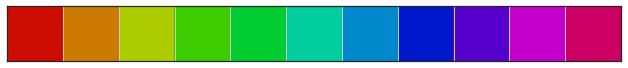

In [2]:
import seaborn as sns
sns.set()
sns.set_style('white')
#sns.set_style('whitegrid')
import matplotlib
plt.rcParams["axes.grid"] = True
plt.rc('font', family='serif')
#plt.rc('font', weight='bold')

current_palette = sns.color_palette(sns.hls_palette(10+1, l=.4, s=1.0))
sns.palplot(current_palette)
current_palette = np.asarray(current_palette)

In [3]:
device = False

setting_dict = {}
random_seed = 1000
setting_dict['random_seed'] = random_seed
setting_dict['init_sample_num'] = 100
setting_dict['lr_hyp'] = 1e-3         #0.001,0.0005  error -- >0.0001 equal_reg
setting_dict['kl_option'] = True   #['True','False']
setting_dict['num_batch'] = 1
setting_dict['tau0'] = 1000
setting_dict['iter'] = 4000        #[5000,8000]
setting_dict['num_rep'] = 2
setting_dict['weight_rate'] = 1e-3  # [1e-2,1e-3,1e-5]
setting_dict['optimizer'] = 'Adam'   #['SGD','Adam']

In [19]:
import numpy as np
import copy

def _initialize_SMkernel_hyp_v2( x_train,y_train, setting_dict, random_seed,weight_option):
    """

    :param y_train:
    :param setting_dict: num_Q,input_dim
    :param random_seed:
    :return:
    """

    np.random.seed(random_seed)
    Num_Q = setting_dict['Num_Q']
    SMKernel_hyp = {}


    input_dim = setting_dict['input_dim']
    if weight_option is True:
        SMKernel_hyp['weight'] = 50*np.random.rand(Num_Q).reshape(-1, 1)
    else:
        SMKernel_hyp['weight'] = (0.99 + 0.02*np.random.rand(Num_Q)).reshape(-1, 1)

        
        
    SMKernel_hyp['std'] = 0.1*np.random.rand(Num_Q ,input_dim)
    SMKernel_hyp['std_prior'] = 0.05*np.random.rand(Num_Q ,input_dim)
    SMKernel_hyp['mean'] = 10*np.random.rand(Num_Q ,input_dim)
    SMKernel_hyp['mean_prior'] = 0.5*np.zeros((Num_Q, input_dim))

    
    SMKernel_hyp['noise_variance'] = 1.0  # real v2
    setting_dict['hypparam'] = SMKernel_hyp

    return copy.deepcopy(setting_dict)


In [20]:
import random


filename = 'SM_Q5_exp1_unequal_v3'
x_train, x_test, x_full, y_train, y_test,y_full,Dataset = _load_collection_syn(filename, cuda_option=device)
x_train_small = x_train[:200]
y_train_small = y_train[:200]




#loaded collection#
/home/yohan/Myenv/Summit_Conference/ICML21_SMapproximation_Sumbit


In [21]:
Q = 5
setting_dict['input_dim'] = x_train.shape[1]
setting_dict['Num_Q'] = Q
setting_dict['noise_err'] = .1*y_train.cpu().data.numpy().std()
setting_dict1 = _initialize_SMkernel_hyp_v2(x_train, y_train, setting_dict, random_seed ,weight_option=True)
setting_dict2 = _initialize_SMkernel_hyp_v2(x_train, y_train, setting_dict, random_seed ,weight_option=False)

In [22]:
def _run_exp(setting_dict0, device, comparison_variable_list, num_Q , weight_option, x_train,y_train):
    digts = 4
    #setting_dict0[]
    setting_dict0['Num_Q'] = num_Q
    setting_dict0 = _initialize_SMkernel_hyp_v2(x_train, y_train, setting_dict, random_seed ,weight_option= weight_option)

    
    ew_fro_mean, ew_fro_std = [],[]
    ew2_fro_mean, ew2_fro_std = [],[]
    ew3_fro_mean, ew3_fro_std = [],[]
    ew4_fro_mean, ew4_fro_std = [],[]

    nw_fro_mean, nw_fro_std = [],[]
    e_fro_mean, e_fro_std = [],[]
    #comparison_variable_list = [2,3,5,10,20] # sampled spectral points

    gpsm = _make_gpmodel(model_name='gpsm', setting_dict=setting_dict0, device=device)
    num_input = x_train.shape[0]
    sm = gpsm._compute_Kxx(x_train).cpu().data.numpy() + (gpsm.likelihood.variance.transform()**2).cpu().data.numpy()*np.eye(num_input)     
    sm_norm = fnorm(sm,'fro')
    
    #print(setting_dict0['hypparam']['weight'])
    
    for ith_sample in comparison_variable_list:
        print(filename + ' ' +str(num_Q))


        setting_dict0['num_sample_pt'] = Q*ith_sample    
    
        rrff_equal = _make_gpmodel(model_name='equal_reg', setting_dict=setting_dict0, device=device)
        rrff_equal._set_data(x_train,y_train)        
        rrff_equal._assign_num_spectralpt(x_train )
        #print( 'rff_equal.num_samplept_list_at '+ str(rrff_equal.num_samplept_list_at))
        
        rrff_naive_weight = _make_gpmodel(model_name='weight_reg', setting_dict=setting_dict0, device=device)
        rrff_naive_weight.sampling_option = 'naive_weight'
        rrff_naive_weight._set_data(x_train,y_train ) 

        rrff_naive_weight._assign_num_spectralpt(x_train , intrain = False)
        
        rrff_exact_weight = _make_gpmodel(model_name='weight_reg', setting_dict=setting_dict0, device=device)
        rrff_exact_weight.spt_manager.rate = 1.0
        rrff_exact_weight._set_data(x_train,y_train) 
        rrff_exact_weight._assign_num_spectralpt(x_train , intrain = False)
        
        rrff_exact_weight_v2 = _make_gpmodel(model_name='weight_reg', setting_dict=setting_dict0, device=device)
        rrff_exact_weight_v2.spt_manager.rate = .05    
        rrff_exact_weight_v2._set_data(x_train,y_train)           
        rrff_exact_weight_v2._assign_num_spectralpt(x_train , intrain = False)
       
    
        rrff_exact_weight_v3 = _make_gpmodel(model_name='weight_reg', setting_dict=setting_dict0, device=device)
        rrff_exact_weight_v3.spt_manager.rate = .1   
        rrff_exact_weight_v3._set_data(x_train,y_train)              
        rrff_exact_weight_v3._assign_num_spectralpt(x_train , intrain = False)        
                
        
        
        ew_fro = []
        ew2_fro = []
        ew3_fro = []
        ew4_fro = []

        nw_fro = []    
        e_fro = []
        for i in range(100):
            asm_ew = rrff_exact_weight._compute_kernel_sm_approximate(x = x_train).cpu().data.numpy()
            asm_ew_v2 = rrff_exact_weight_v2._compute_kernel_sm_approximate(x = x_train).cpu().data.numpy()
            asm_ew_v3 = rrff_exact_weight_v3._compute_kernel_sm_approximate(x = x_train).cpu().data.numpy()

            asm_nw = rrff_naive_weight._compute_kernel_sm_approximate(x = x_train).cpu().data.numpy()        
            asm_e = rrff_equal._compute_kernel_sm_approximate(x = x_train).cpu().data.numpy()    



            ew_fro.append(fnorm(sm-asm_ew,'fro'))
            ew2_fro.append(fnorm(sm-asm_ew_v2,'fro'))
            ew3_fro.append(fnorm(sm-asm_ew_v3,'fro'))
            nw_fro.append(fnorm(sm-asm_nw,'fro'))
            e_fro.append(fnorm(sm-asm_e,'fro'))        


        ew_fro_mean.append(np.around(np.asarray(ew_fro).mean(),digts))
        ew_fro_std.append(np.around(np.asarray(ew_fro).std(),digts))

        ew2_fro_mean.append(np.around(np.asarray(ew2_fro).mean(),digts))
        ew2_fro_std.append(np.around(np.asarray(ew2_fro).std(),digts))

        ew3_fro_mean.append(np.around(np.asarray(ew3_fro).mean(),digts))
        ew3_fro_std.append(np.around(np.asarray(ew3_fro).std(),digts))

        nw_fro_mean.append(np.around(np.asarray(nw_fro).mean(),digts))
        nw_fro_std.append(np.around(np.asarray(nw_fro).std(),digts))

        e_fro_mean.append(np.around(np.asarray(e_fro).mean(),digts))
        e_fro_std.append(np.around(np.asarray(e_fro).std(),digts))


        print(ew_fro_mean,ew_fro_std)
        print(ew2_fro_mean,ew2_fro_std)    
        print(ew3_fro_mean,ew3_fro_std)    
#        print(ew4_fro_mean,ew4_fro_std)    

        print(nw_fro_mean,nw_fro_std)    
        print(e_fro_mean,e_fro_std)

        print('')

    return ew_fro_mean,ew_fro_std,\
           ew2_fro_mean,ew2_fro_std,\
           ew3_fro_mean,ew3_fro_std,\
           nw_fro_mean,nw_fro_std,\
           e_fro_mean,e_fro_std
       

## experiments over varying SPT

In [23]:
#num_Q = 5
num_Q_list = [5,25]
comparison_variable_list = [2,3,10]

In [24]:
ew_fro_mean_list,ew_fro_std_list = [],[]
ew2_fro_mean_list,ew2_fro_std_list = [],[]
ew3_fro_mean_list,ew3_fro_std_list = [],[]
nw_fro_mean_list,nw_fro_std_list = [],[]
e_fro_mean_list,e_fro_std_list = [],[]

### extremely different weight initialzation

In [25]:
for num_Q in num_Q_list:
    print(num_Q)
    ew_fro_mean,ew_fro_std,\
    ew2_fro_mean,ew2_fro_std,\
    ew3_fro_mean,ew3_fro_std,\
    nw_fro_mean,nw_fro_std,\
    e_fro_mean,e_fro_std = _run_exp(setting_dict1,device,comparison_variable_list, num_Q, True, x_train_small,y_train_small)

    ew_fro_mean_list.append(ew_fro_mean)
    ew_fro_std_list.append(ew_fro_std)
    
    ew2_fro_mean_list.append(ew2_fro_mean)
    ew2_fro_std_list.append(ew2_fro_std)

    ew3_fro_mean_list.append(ew3_fro_mean)
    ew3_fro_std_list.append(ew3_fro_std)

    nw_fro_mean_list.append(nw_fro_mean)
    nw_fro_std_list.append(nw_fro_std)

    e_fro_mean_list.append(e_fro_mean)
    e_fro_std_list.append(e_fro_std)
    

5
SM_Q5_exp1_unequal_v3 5
[608.6663] [226.4878]
[642.5452] [251.1185]
[650.283] [266.6201]
[684.3287] [287.8955]
[840.2817] [362.6252]

SM_Q5_exp1_unequal_v3 5
[608.6663, 571.0877] [226.4878, 224.0196]
[642.5452, 528.3193] [251.1185, 192.0102]
[650.283, 507.2957] [266.6201, 176.6598]
[684.3287, 560.7555] [287.8955, 232.602]
[840.2817, 648.0311] [362.6252, 286.3986]

SM_Q5_exp1_unequal_v3 5
[608.6663, 571.0877, 299.4563] [226.4878, 224.0196, 117.4163]
[642.5452, 528.3193, 313.9499] [251.1185, 192.0102, 122.3488]
[650.283, 507.2957, 303.5291] [266.6201, 176.6598, 121.9336]
[684.3287, 560.7555, 308.1306] [287.8955, 232.602, 129.822]
[840.2817, 648.0311, 360.3759] [362.6252, 286.3986, 155.7325]

25
SM_Q5_exp1_unequal_v3 25
[645.0668] [303.767]
[694.2408] [246.0356]
[673.6426] [250.6268]
[726.144] [317.8104]
[753.4483] [331.3848]

SM_Q5_exp1_unequal_v3 25
[645.0668, 545.9983] [303.767, 210.2029]
[694.2408, 529.2525] [246.0356, 205.9034]
[673.6426, 559.3008] [250.6268, 197.5571]
[726.144, 54

In [26]:
wspace = .5  # the amount of width reserved for space between subplots,
              # expressed as a fraction of the average axis width
hspace = .4  # the amount of height reserved for space between subplots,
              # expressed as a fraction of the average axis height
    
figsiz = (7.2*2,4.4)


In [27]:
legend_tag = ['proposed r=1.0','proposed r=0.05','proposed r=0.1','naive weight','equal']
color_tag = current_palette[[0,1,4,7,8]] 

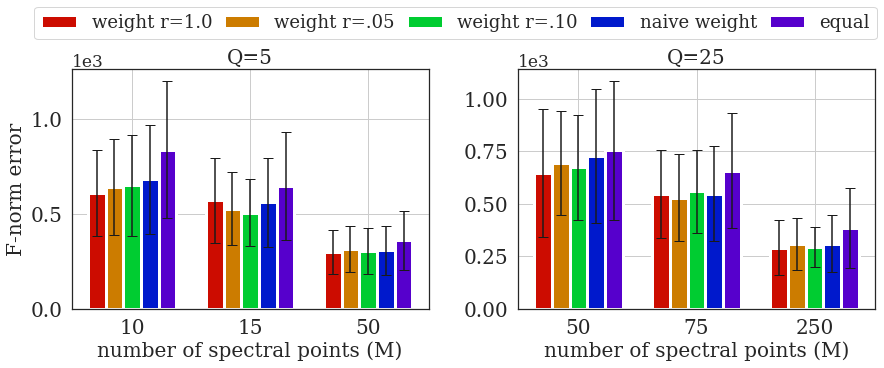

In [28]:
from matplotlib.ticker import StrMethodFormatter


wspace = .25 # the amount of width reserved for space between subplots,
              # expressed as a fraction of the average axis width
hspace = .085  # the amount of height reserved for space between subplots,
              # expressed as a fraction of the average axis height
    
#legend_tag = ['proposed r=1.0','proposed r=0.05','proposed r=0.1','naive weight','equal']
legend_tag2 = ['weight r=1.0','weight r=.05','weight r=.10','naive weight','equal']

color_tag = current_palette[[0,1,4,7,8]] 



c = 20
fig = plt.figure(figsize = figsiz)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)


#for ew_fro_mean in num_
for ith in range(len(num_Q_list)):
    plt.subplot(1,2,ith+1)
    #ticklabel = [str(i) for i in comparison_variable_Qlist]
    #ind = np.arange(len(Qew_fro_mean))  # the x locations for the groups
    width = 0.9  # the width of the bars

    Q_means_list,Q_stds_list = [],[]
    Q_means_list.append( ew_fro_mean_list[ith])
    Q_means_list.append( ew2_fro_mean_list[ith])
    Q_means_list.append( ew3_fro_mean_list[ith])
    Q_means_list.append( nw_fro_mean_list[ith])
    Q_means_list.append( e_fro_mean_list[ith])
    
    Q_stds_list.append( ew_fro_std_list[ith])
    Q_stds_list.append( ew2_fro_std_list[ith])
    Q_stds_list.append( ew3_fro_std_list[ith])
    Q_stds_list.append( nw_fro_std_list[ith])
    Q_stds_list.append( e_fro_std_list[ith])
    
    
    #ticklabel = [str(i) for i in comparison_variable_Qlist]
    ticklabel = [str(spt*num_Q_list[ith]) for spt in comparison_variable_list]  
    ind = 1*np.arange(len(comparison_variable_list))  # the x locations for the groups
    width = 0.9  # the width of the bars    

    for iith,(ith_mean,ith_std) in enumerate(zip(Q_means_list,Q_stds_list)):
        plt.bar(ind + (-2+iith)*width/6  , ith_mean , width/6, yerr= ith_std ,linewidth=3 , capsize=5 , label= legend_tag2[iith]  , color = color_tag[iith] )

    plt.xticks( ind , ticklabel)
    plt.xlabel('number of spectral points (M)',fontsize = 20)
    plt.tick_params(axis='both', which='major', labelsize= 20)

    
    
    plt.gca().yaxis.get_offset_text().set_size(17)
    plt.title('Q={}'.format(num_Q_list[ith]), fontsize= 20)
    plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0) )

    if ith == 0:
        plt.ylabel('F-norm error',fontsize = 20)

    

plt.legend(bbox_to_anchor=(.85,1.5),fontsize = 18, ncol = 4)
leg = plt.legend(bbox_to_anchor=(1.03,1.25),fontsize = 18.0, ncol = 5 , columnspacing = 0.65)
leg = plt.legend(bbox_to_anchor=(1.03,1.3),fontsize = 18.0, ncol = 5 , columnspacing = 0.65)
for line in leg.get_lines():
    line.set_linewidth(4)    
    





# equal weight inialization

In [29]:
ew_fro_mean_list2,ew_fro_std_list2 = [],[]
ew2_fro_mean_list2,ew2_fro_std_list2 = [],[]
ew3_fro_mean_list2,ew3_fro_std_list2 = [],[]
nw_fro_mean_list2,nw_fro_std_list2 = [],[]
e_fro_mean_list2,e_fro_std_list2 = [],[]

In [30]:
for num_Q in num_Q_list:
    print(num_Q)
    ew_fro_mean,ew_fro_std,\
    ew2_fro_mean,ew2_fro_std,\
    ew3_fro_mean,ew3_fro_std,\
    nw_fro_mean,nw_fro_std,\
    e_fro_mean,e_fro_std = _run_exp(setting_dict1,device,comparison_variable_list, num_Q, False, x_train_small,y_train_small)

    ew_fro_mean_list2.append(ew_fro_mean)
    ew_fro_std_list2.append(ew_fro_std)
    
    ew2_fro_mean_list2.append(ew2_fro_mean)
    ew2_fro_std_list2.append(ew2_fro_std)

    ew3_fro_mean_list2.append(ew3_fro_mean)
    ew3_fro_std_list2.append(ew3_fro_std)

    nw_fro_mean_list2.append(nw_fro_mean)
    nw_fro_std_list2.append(nw_fro_std)

    e_fro_mean_list2.append(e_fro_mean)
    e_fro_std_list2.append(e_fro_std)
    

5
SM_Q5_exp1_unequal_v3 5
[16.5366] [7.109]
[16.149] [5.6104]
[17.1585] [7.1944]
[19.3883] [6.6559]
[18.3849] [7.3593]

SM_Q5_exp1_unequal_v3 5
[16.5366, 14.2161] [7.109, 5.9134]
[16.149, 12.558] [5.6104, 4.2171]
[17.1585, 14.5209] [7.1944, 5.7007]
[19.3883, 16.9319] [6.6559, 7.3594]
[18.3849, 15.5455] [7.3593, 6.2415]

SM_Q5_exp1_unequal_v3 5
[16.5366, 14.2161, 7.4569] [7.109, 5.9134, 2.495]
[16.149, 12.558, 7.7204] [5.6104, 4.2171, 2.6023]
[17.1585, 14.5209, 7.3785] [7.1944, 5.7007, 2.6121]
[19.3883, 16.9319, 8.5522] [6.6559, 7.3594, 3.4958]
[18.3849, 15.5455, 9.4462] [7.3593, 6.2415, 3.1966]

25
SM_Q5_exp1_unequal_v3 25
[16.6356] [6.1169]
[16.0968] [5.7519]
[17.1528] [6.7244]
[21.8324] [9.3827]
[20.2417] [7.3721]

SM_Q5_exp1_unequal_v3 25
[16.6356, 13.9485] [6.1169, 4.9332]
[16.0968, 13.2219] [5.7519, 4.9201]
[17.1528, 13.2774] [6.7244, 5.5035]
[21.8324, 15.9315] [9.3827, 6.0072]
[20.2417, 16.4839] [7.3721, 6.7448]

SM_Q5_exp1_unequal_v3 25
[16.6356, 13.9485, 7.8558] [6.1169, 4.9332

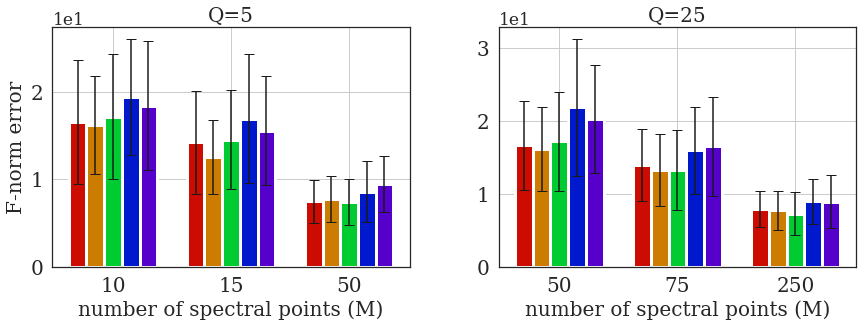

In [31]:
from matplotlib.ticker import StrMethodFormatter


wspace = .25 # the amount of width reserved for space between subplots,
              # expressed as a fraction of the average axis width
hspace = .085  # the amount of height reserved for space between subplots,
              # expressed as a fraction of the average axis height
    
legend_tag2 = ['weight r=1.0','weight r=.05','weight r=.10','naive weight','equal']

color_tag = current_palette[[0,1,4,7,8]] 



c = 20
fig = plt.figure(figsize = figsiz)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)


#for ew_fro_mean in num_
for ith in range(len(num_Q_list)):
    plt.subplot(1,2,ith+1)
    width = 0.9  # the width of the bars

    Q_means_list,Q_stds_list = [],[]
    Q_means_list.append( ew_fro_mean_list2[ith])
    Q_means_list.append( ew2_fro_mean_list2[ith])
    Q_means_list.append( ew3_fro_mean_list2[ith])
    Q_means_list.append( nw_fro_mean_list2[ith])
    Q_means_list.append( e_fro_mean_list2[ith])
    
    Q_stds_list.append( ew_fro_std_list2[ith])
    Q_stds_list.append( ew2_fro_std_list2[ith])
    Q_stds_list.append( ew3_fro_std_list2[ith])
    Q_stds_list.append( nw_fro_std_list2[ith])
    Q_stds_list.append( e_fro_std_list2[ith])
    
    
    #ticklabel = [str(i) for i in comparison_variable_Qlist]
    ticklabel = [str(spt*num_Q_list[ith]) for spt in comparison_variable_list]  
    ind = 1*np.arange(len(comparison_variable_list))  # the x locations for the groups
    width = 0.9  # the width of the bars    

    for iith,(ith_mean,ith_std) in enumerate(zip(Q_means_list,Q_stds_list)):
        plt.bar(ind + (-2+iith)*width/6  , ith_mean , width/6, yerr= ith_std ,linewidth=3 , capsize=5 , label= legend_tag2[iith]  , color = color_tag[iith] )

    plt.xticks( ind , ticklabel)
    plt.xlabel('number of spectral points (M)',fontsize = 20)
    plt.tick_params(axis='both', which='major', labelsize= 20)
    plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0) )
    plt.gca().yaxis.get_offset_text().set_size(17)
    #plt.title('M=Q x 3', fontsize= 20)
    plt.title('Q={}'.format(num_Q_list[ith]), fontsize= 20)

    
    if ith == 0:
        plt.ylabel('F-norm error',fontsize = 20)




